<a href="https://colab.research.google.com/github/flyaflya/persuasive/blob/main/demoNotebooks/carsFixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install matplotlib numpyro daft --upgrade  ##restart runtime

## Get the Data

In [1]:
import pandas as pd
url = "https://raw.githubusercontent.com/flyaflya/persuasive/main/carsFixed.csv"
carsDF = pd.read_csv(url)
carsDF

,observation,shopID,boss,carsFixed
0,1,1,0,8
1,2,2,0,22
2,3,3,0,32
3,4,4,1,64
4,5,5,0,53
...,...,...,...,...
245,246,1,1,18
246,247,2,0,22
247,248,3,0,31
248,249,4,0,26


In [2]:
(
    carsDF
    .groupby(carsDF.shopID)
    .agg(numObservations=('observation', 'count'), 
        numBossVisits =('boss', 'sum'))
)

,numObservations,numBossVisits
shopID,,
1,50,10
2,50,5
3,50,15
4,50,5
5,50,15


## Using carsDF, create a numpyro model for cars fixed by shop
Assume carsFixed is poisson, ignore the effect of the boss.  What estimates do you get for lambda?   It might be easier to start with ignoring shop and then adding it later.

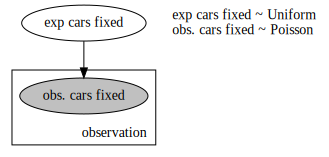

In [9]:
import xarray as xr
import numpy as np
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, NUTS
import arviz as az

## define the graphical/statistical model as a Python function
def fixedCarsModel(k):
    ## NOTE LAMBDA IS RESERVED WORD IN PYTHON... MUST USE MODIFIED NAME
    lambdaParam = numpyro.sample('exp cars fixed', dist.Uniform(low = 0, high = 120))
    
    with numpyro.plate('observation', len(k)):
        k = numpyro.sample('obs. cars fixed', dist.Poisson(rate = lambdaParam), obs = k)

numpyro.render_model(fixedCarsModel, model_args = (carsDF.carsFixed.values,), render_distributions = True)

In [10]:
# ## computationally get posterior distribution
mcmc = MCMC(NUTS(fixedCarsModel), num_warmup=1000, num_samples=4000) 
rng_key = random.PRNGKey(seed = 111) ## so you and I get same results
mcmc.run(rng_key, k=carsDF.carsFixed.values) ## get representative sample of posterior

sample: 100%|██████████| 5000/5000 [00:07<00:00, 689.02it/s, 3 steps of size 1.18e+00. acc. prob=0.90] 


<AxesSubplot:title={'center':'exp cars fixed'}>

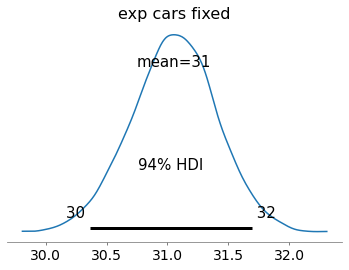

In [11]:
drawsDS = az.from_numpyro(mcmc).posterior ## get posterior samples into xarray
az.plot_posterior(drawsDS)

## have different lambda value for each shop

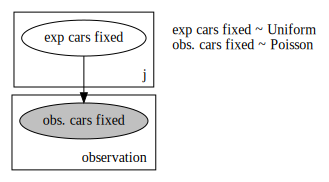

In [17]:
## define the graphical/statistical model as a Python function
def fixedCarsModel(k, shopID):
    ## NOTE LAMBDA IS RESERVED WORD IN PYTHON... MUST USE MODIFIED NAME
    with numpyro.plate("j", len(np.unique(shopID))):
        lambdaParam = numpyro.sample('exp cars fixed', dist.Uniform(low = 0, high = 120))
    
    with numpyro.plate('observation', len(k)):
        k = numpyro.sample('obs. cars fixed', dist.Poisson(rate = lambdaParam[shopID]), obs = k)

numpyro.render_model(fixedCarsModel, model_args = (carsDF.carsFixed.values, carsDF.shopID.values), render_distributions = True)

In [21]:
# ## computationally get posterior distribution
mcmc = MCMC(NUTS(fixedCarsModel), num_warmup=1000, num_samples=4000) 
rng_key = random.PRNGKey(seed = 111) ## so you and I get same results
mcmc.run(rng_key, k=carsDF.carsFixed.values, shopID = carsDF.shopID.values-1) ## get representative sample of posterior

sample: 100%|██████████| 5000/5000 [00:07<00:00, 675.08it/s, 7 steps of size 8.37e-01. acc. prob=0.88] 


array([[<AxesSubplot:title={'center':'exp cars fixed\n0'}>,
        <AxesSubplot:title={'center':'exp cars fixed\n1'}>,
        <AxesSubplot:title={'center':'exp cars fixed\n2'}>],
       [<AxesSubplot:title={'center':'exp cars fixed\n3'}>,
        <AxesSubplot:title={'center':'exp cars fixed\n4'}>,
        <AxesSubplot:>]], dtype=object)

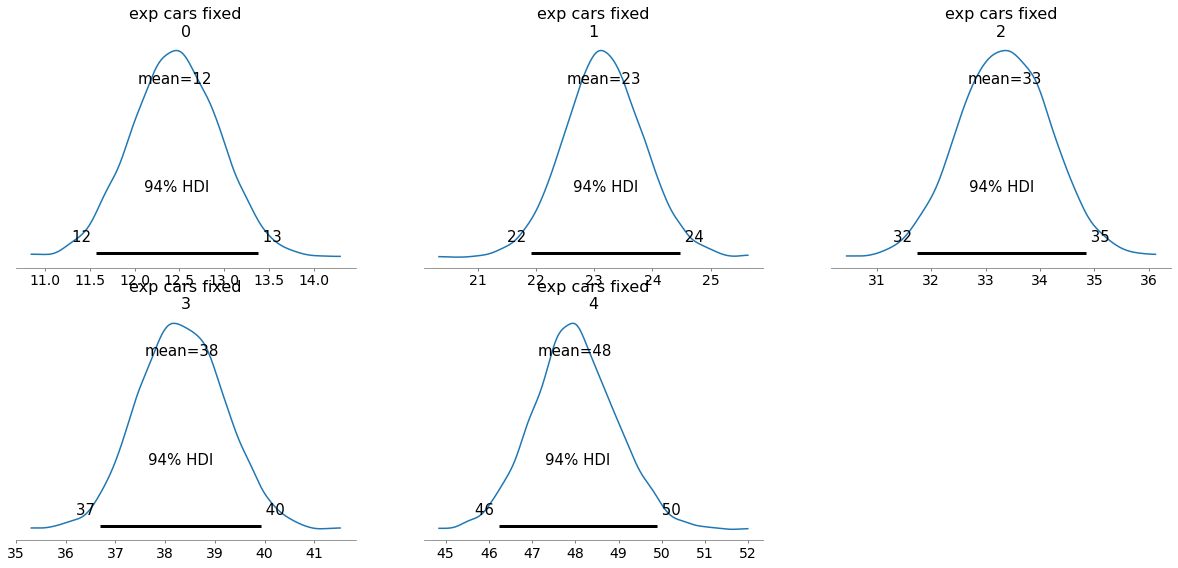

In [22]:
drawsDS = az.from_numpyro(mcmc).posterior ## get posterior samples into xarray
az.plot_posterior(drawsDS)